In [1]:
%matplotlib notebook
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz

from keras.layers.core import Lambda
from keras import backend as K    
    
def Get_Feats_and_Targets(filename):
    import numpy as np
    
    def line_to_Feats(line):
        line = line.split(' ')
        Feats = np.asarray(line[0:1024])
        Target = np.zeros([3])
        Target[int(line[1024])] = 1
        return Feats,Target

    f = open(filename, 'r')
    lines = f.readlines()
    Features = []
    Targets = []
    for i in range(len(lines)-1):
        line = lines[i+1]
        Feats,Tgts = line_to_Feats(line)
        Features.append(Feats)
        Targets.append(Tgts)
        
    return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')



def mini_batches(InputSample,BatchSize):
    Index = np.array(range(InputSample.shape[0]),dtype=int)
    NumBatches = np.int(InputSample.shape[0]/BatchSize)
    Removed = np.array([],dtype=int)

    BatchInd =[]
    for BatchLoop in range(NumBatches):
        RemainIndex = np.delete(Index,Removed)
        SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
        Removed = np.append(Removed,SampleInd,axis=0)

        BatchInd.append(SampleInd)
    RemainIndex = np.delete(Index,Removed)
    BatchInd.append(RemainIndex)
    
    return BatchInd,NumBatches

In [2]:
[TrainInputs,TrainTargets] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.10000.train.amat')

[ValInputs,ValTargets] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.5000.valid.amat')

In [3]:
data_dim = TrainInputs.shape[-1]
NumSamples = TrainInputs.shape[0]
Num_Targets = TrainTargets.shape[-1]

index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

reg_coeff = 0.0005

def Gen_Model(reg_coeff):
    model = Sequential()
    model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
#     model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
#     model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.sgd(lr=0.001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
    
    return model
    
ISHard_model = Gen_Model(reg_coeff)

ISEasy_model = Gen_Model(reg_coeff)

Uni_model = Gen_Model(reg_coeff)

ISHard_model.set_weights(Uni_model.get_weights())
ISEasy_model.set_weights(Uni_model.get_weights())

In [4]:
def acquisition_function_dist_to_threshold(model,samples,Num_Targets,Smoothing_Const=0,Rescale=0):
    Output = model.predict(samples)
    Output -= 1/Num_Targets
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold) + Smoothing_Const
    Exp_Dist_to_Threshold *= 10
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
    if Rescale == 1:
        Median_Prob = np.median(Sampling_Prob)
        Min_Prob = np.min(Sampling_Prob)
        Sampling_Prob[Sampling_Prob > Median_Prob] += Min_Prob/2
        Sampling_Prob[Sampling_Prob < Median_Prob] -= Min_Prob/2
    return Sampling_Prob


def Exp_ModelChange(Model,Inputs,Num_Targets):
    ExpChange = np.zeros(Inputs.shape[0])
    for TargetLoop in range(Num_Targets):
        thisTarget = np.zeros([Inputs.shape[0],Num_Targets])
        thisTarget[:,TargetLoop] = 1
        Model_Output = Model.predict(Inputs)
        ClassProb = Model_Output[:,TargetLoop]
        Loss = np.mean(Model_Output - Model_Output*thisTarget + np.log(1+np.exp(-Model_Output)),1)
        ExpChange += Loss*ClassProb
    return ExpChange

def acquisition_function_exp_model_change(model,samples,Num_Targets,Smoothing_Const=0,Rescale=0):
    ExpChange = Exp_ModelChange(model,samples,Num_Targets) + Smoothing_Const
    Sampling_Prob = ExpChange/np.sum(ExpChange)
    if Rescale == 1:
        Median_Prob = np.median(Sampling_Prob)
        Min_Prob = np.min(Sampling_Prob)
        Sampling_Prob[Sampling_Prob > Median_Prob] += Min_Prob/2
        Sampling_Prob[Sampling_Prob < Median_Prob] -= Min_Prob/2
    return Sampling_Prob

def Get_L2_Loss(Model,Coeff=0.01):
    Reg_Loss = 0
    Weights = Model.get_weights()
    NumWeights = len(Weights)
    for i in range(NumWeights):
        LayerWeights = Weights[i]
        LayerWeights_Sq = LayerWeights**2
        Reg_Loss += LayerWeights_Sq.sum()
    Reg_Loss*=Coeff
    return Reg_Loss


def acquisition_function_exp_model_change(model,samples,Num_Targets,Smoothing_Const=0,Rescale=0):
    ExpChange = Exp_ModelChange(model,samples,Num_Targets) + Smoothing_Const
    ExpChange = ExpChange/np.sum(ExpChange)
    
    if Rescale == 1:
        Median_Prob = np.median(ExpChange)
        Min_Prob = np.min(ExpChange)
        ExpChange[ExpChange > Median_Prob] += Min_Prob/2
        ExpChange[ExpChange < Median_Prob] -= Min_Prob/2
    return ExpChange


def ablate_network(model,ablation_perc):
    weights = model.get_weights()
    save_weights = weights.copy()
    NumLayers = len(weights)
    total_numweights  = 0 
    for i in range(NumLayers):
        layer = weights[i]
        total_numweights += len(layer.flatten())
    num_ablations = np.int(ablation_perc*total_numweights)
    weights = ablate_weights(weights,num_ablations)
    model.set_weights(weights)
        
    return(model,save_weights)


def ablation_curve(model,num_tests,max_perc,inputs,targets):
    Perc_Space = np.linspace(0,max_perc,num_tests)
    Performance = np.zeros(num_tests)
    for i in range(num_tests):
        model,save_weights = ablate_network(model,Perc_Space[i])
        Perf = model.test_on_batch(inputs,targets)
        Performance[i] = Perf[1]
        model.set_weights(save_weights)
        AUC = trapz(Performance,Perc_Space)
        
    return AUC,Performance
    
    
def ablate_weights(weights,num_ablations):
    NumLayers = len(weights)
    LayerShape = []
    LayerShape = []
    LayerNodes = [0]
    FlattenedNodes = np.empty([0])
    for i in range(NumLayers):
        LayerShape.append(weights[i].shape)
        LayerNodes.append(len(weights[i].flatten()))
        FlattenedNodes = np.append(FlattenedNodes,weights[i].flatten())
        Index = np.linspace(0,len(FlattenedNodes)-1,num=len(FlattenedNodes),dtype = int)
    RandChoice = np.random.choice(Index,size = num_ablations,replace=False)
    FlattenedNodes[RandChoice] = 0
    FirstInd = 0
    for i in range(NumLayers):
        FirstInd += LayerNodes[i]
        SecondInd = FirstInd + LayerNodes[i+1]
        Sample = FlattenedNodes[FirstInd:SecondInd]
        Sample = Sample.reshape(LayerShape[i])
        weights[i] = Sample
        
    return weights


def acquisition_function_ablation(model,Inputs,Targets,Cluster_Size,Rescale):
    BatchInd,NumBatches = mini_batches(Inputs,Cluster_Size)
    AUC_Record = np.zeros([Inputs.shape[0]])
    count= 0
    for Batch in BatchInd:
        if Batch.shape[0] != 0:
            BatchInputs = Inputs[Batch,:]
            BatchTargets = Targets[Batch,:]
            SaveWeights = model.get_weights()
            model.fit(BatchInputs,BatchTargets,batch_size=64,verbose=0)
            AUC,_ = ablation_curve(model,10,1,Inputs,Targets)
            AUC_Record[Batch] = AUC.copy()
            model.set_weights(SaveWeights)
            count +=1
        
    Sampling_Prob = AUC_Record/AUC_Record.sum()
    
    if Rescale == 1:
        Median_Prob = np.median(Sampling_Prob)
        Min_Prob = np.min(Sampling_Prob)
        Sampling_Prob[Sampling_Prob > Median_Prob] += Min_Prob/2
        Sampling_Prob[Sampling_Prob < Median_Prob] -= Min_Prob/2
    
    return Sampling_Prob
    
    


In [5]:
count = 0 
Num_Epochs = 300
Num_BurnIn = 10
Batch_Size = 64

Smoothing_Constant = 0

Val_Error = np.zeros([Num_Epochs,3])
Val_Acc = np.zeros([Num_Epochs,3])

<IPython.core.display.Javascript object>


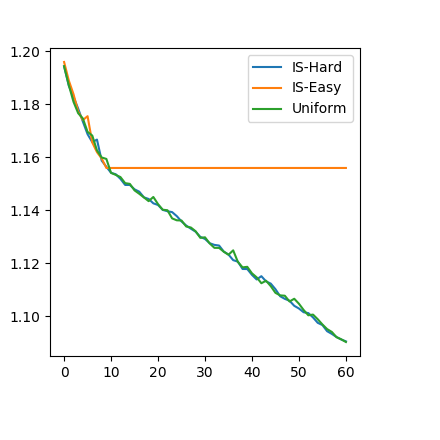

<IPython.core.display.Javascript object>


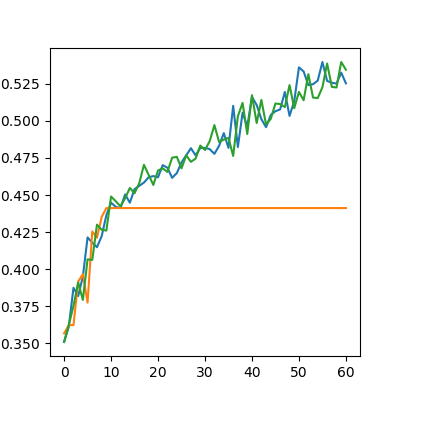

0
1
2
3
4
5
6
7
8
9
1.0470529868551082
10
1.0321648665150212
11
1.0459821275564636
12
1.031081211550665
13
1.0301060230201236
14
1.0550773153056936
15
1.031435729779711
16
1.0317958933442979
17
1.034948078592068
18
1.0516040842240086
19
1.055741083419543
20
1.0369029548402715
21
1.0471072731578885
22
1.0475053887055392
23
1.0559095825510905
24
1.0470834658102146
25
1.0506560715116289
26
1.0495220111049777
27
1.0503245613015333
28
1.0696840606988203
29
1.0345450747967746
30
1.0435978085573137
31
1.0448930816496182
32
1.055848560700353
33
1.0675723179601633
34
1.037504212837081
35
1.0672968069495938
36
1.0679811355647955
37
1.0379397621303672
38
1.0376011409400785
39
1.0482305412232582
40
1.044044382199308
41
1.0609262582037051
42
1.0680472048544603
43
1.0441136593915974
44
1.0559778379852145
45
1.0335367420931882
46
1.0603120740185534
47
1.0576786831701916
48
1.0568748280609204
49
1.0725434051369718
50
1.0616749411647841
51
1.0426096309649808
52
1.0683605777670593
53
1.051442974137098
5

KeyboardInterrupt: 

In [6]:
fig = plt.figure(figsize = [4,4])
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

fig2 = plt.figure(figsize = [4,4])
ax2 = fig2.add_subplot(111)
plt.ion()
fig2.show()
fig2.canvas.draw()


def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1):
    while True: 
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
#         Sampling_Probability = Sampling_Probability/Sampling_Probability.sum()
        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])
            
        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)


for EpochLoop in  range(Num_Epochs):
    if count < Num_BurnIn:
        ISHard_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        ISEasy_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]

        Uni_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]
    else:
        Hard_Sampling_Probability = acquisition_function_ablation(ISHard_model,TrainInputs,TrainTargets,500,-1)
#         Easy_SamplingProbability = 1/acquisition_function_ablation(ISEasy_model,TrainInputs,TrainTargets,500,-1)
#         Easy_SamplingProbability/= Easy_SamplingProbability.sum().astype(float)
        
        print(Hard_Sampling_Probability.max()/Hard_Sampling_Probability.min())
        
        ISHard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Hard_Sampling_Probability,1),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
#         ISEasy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Easy_SamplingProbability,0),
#                                  steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/(NumSamples*np.ones(NumSamples))),
                                steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        
        Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]
        
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]

    print(count)
    
    ax.clear()
    ax.plot(Val_Error[0:count,0],label='IS-Hard')
    ax.plot(Val_Error[0:count,1],label='IS-Easy')
    ax.plot(Val_Error[0:count,2],label='Uniform')
    ax.legend()
    fig.canvas.draw()
    
    ax2.clear()
    ax2.plot(Val_Acc[0:count,0],label='IS-Hard')
    ax2.plot(Val_Acc[0:count,1],label='IS-Easy')
    ax2.plot(Val_Acc[0:count,2],label='Uniform')
    fig2.canvas.draw()
    
    count += 1

In [ ]:
[TestInputs,TestTargets] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.5000.test.amat')

In [8]:
TestError = np.zeros([3,2])
TestError[0,:] = ISHard_model.test_on_batch(TestInputs,TestTargets)
TestError[1,:] = ISEasy_model.test_on_batch(TestInputs,TestTargets)
TestError[2,:] = Uni_model.test_on_batch(TestInputs,TestTargets)

In [9]:
TestError

array([[0.82143617, 0.7378    ],
       [0.81875712, 0.736     ],
       [0.8356421 , 0.7256    ]])

In [19]:
test = acquisition_function_ablation(ISHard_model,TrainInputs,TrainTargets,500)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [7]:
import seaborn as sns

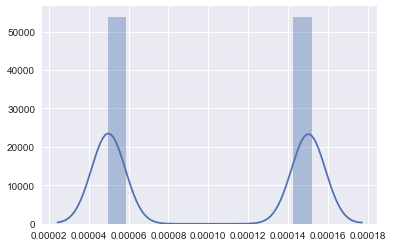

In [8]:
%matplotlib inline
sns.distplot(Easy_SamplingProbability)